### quantify site specific greenery 

source data: berlin geoportal: shapefile with polygones and concrete green volume in m3 per m2

output variables:

`GVI_x`: Green Volume Index as weighted average for radius size x = [25,50,75,100,200]

`LAI`: factor of leaf area index/ change of biomass over time

In [36]:
# 1 load data and select features
import geopandas

sites = geopandas.read_file('../data/monitoring_station/monitoring_station.shp')[['id', 'geometry']]
greenery = geopandas.read_file('../data/green_volume/green_volume.shp')[['vegvol2020', 'geometry']]

# 1.2 check reference system - no adjustment needed 
print(f'Coordinate Reference System monitoring sites: {sites.crs}')
print(f'Coordinate Reference System green volume: {greenery.crs}')

Coordinate Reference System monitoring sites: EPSG:25833
Coordinate Reference System green volume: EPSG:25833


In [37]:
# calculate weight mean vegetation volume index (VVI) for different radius sizes and different sites and append to df
import geopandas 
import pandas
import matplotlib.pyplot as plt

def calc_GVI(coordinate, radius, id, plot = False):
    
    # intersect radius with map of greenery
    buffer  = geopandas.GeoDataFrame(geometry= [coordinate.buffer(radius)], crs=greenery.crs) # create polygon with buffer region around monitoring point
    in_buffer_one = geopandas.overlay(greenery, buffer, how='intersection') # intersect block areas (with vegetation volume) with radius polygon to reduce block areas inside the radius 
    
    # calculate weighted mean of vegetation volume inside each circle
    in_buffer_one['area'] = in_buffer_one['geometry'].area # area for each block inside circle  
    in_buffer_one['factor_greenery'] = in_buffer_one['area'] / in_buffer_one['area'].sum() # weight= relative proportion of subarea from total area inside circle (sum == 1)
    in_buffer_one['weighted_greenery'] = (in_buffer_one['factor_greenery']) * in_buffer_one['vegvol2020'] # weight
    current_GVI = round(in_buffer_one['weighted_greenery'].sum(),3) # absolute VVI as sum of weighted area index

  
    # plot buffer zones 
    if plot == True: 
        ax = in_buffer_one.plot(column='vegvol2020', cmap='Greens', legend=True, edgecolor='black', vmin= 0, vmax = 10,)
        ax.set_title(f'{id}: Green Volume Index: {current_GVI}')
        ax.set_xticks([])
        ax.set_yticks([])
        plt.savefig(f"output/green_volume/GVI_{(id.lower()).replace(' ','')}_{radius}.png", dpi = 300)
        plt.show()
    
    return current_GVI

# apply for all radius and all sites
for radius in [25, 50, 100, 200]:
    sites[f'GVI_{radius}'] = sites.apply(lambda row: calc_GVI(coordinate=row['geometry'], radius=radius, id=row['id'], plot = False), axis=1)



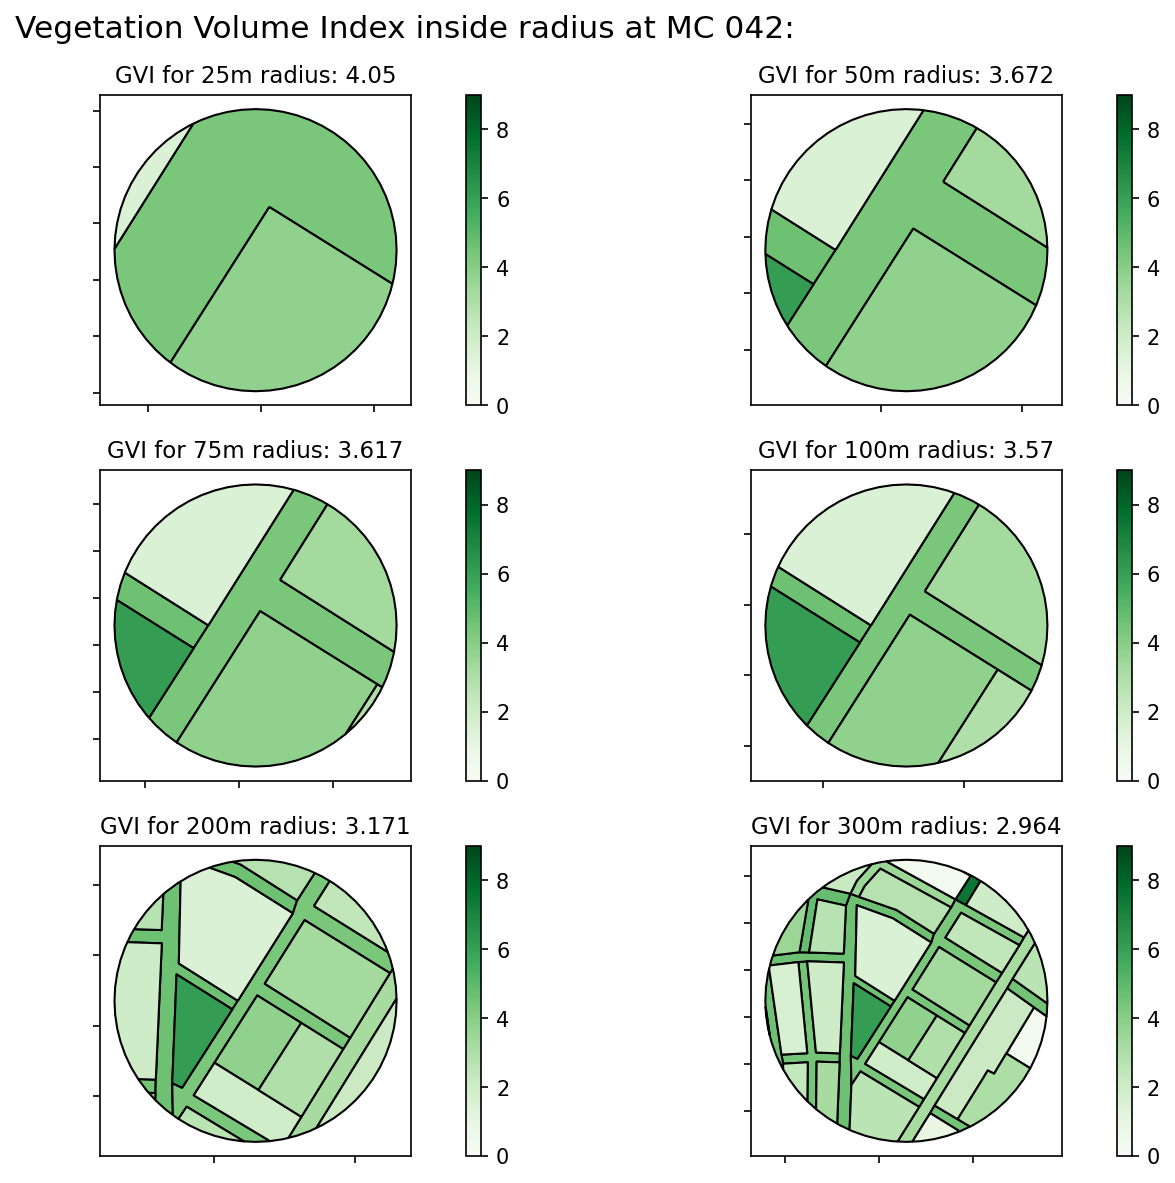

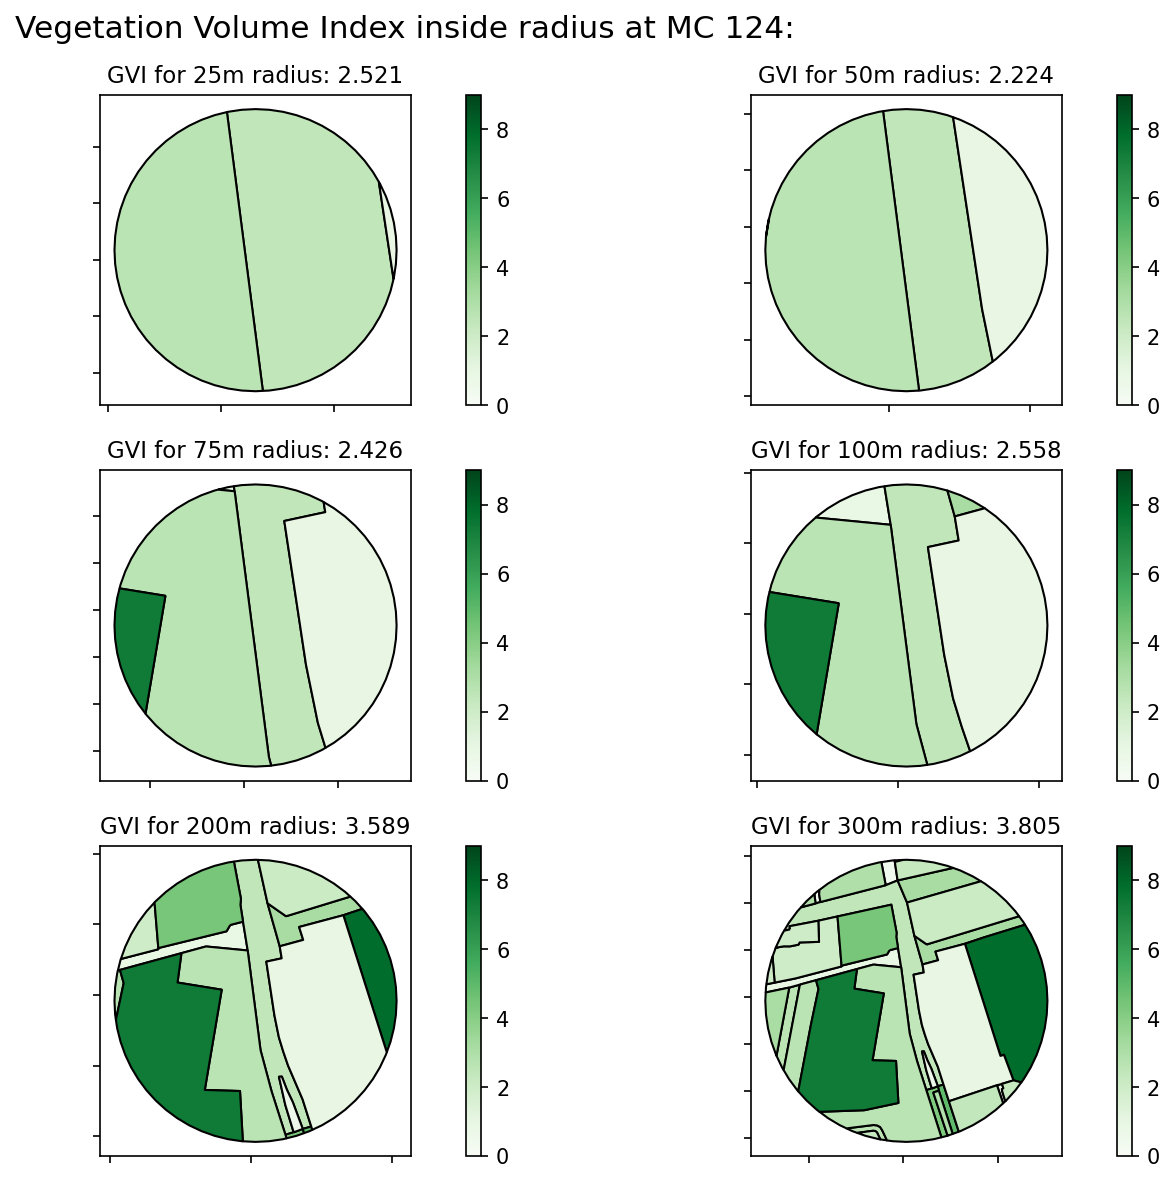

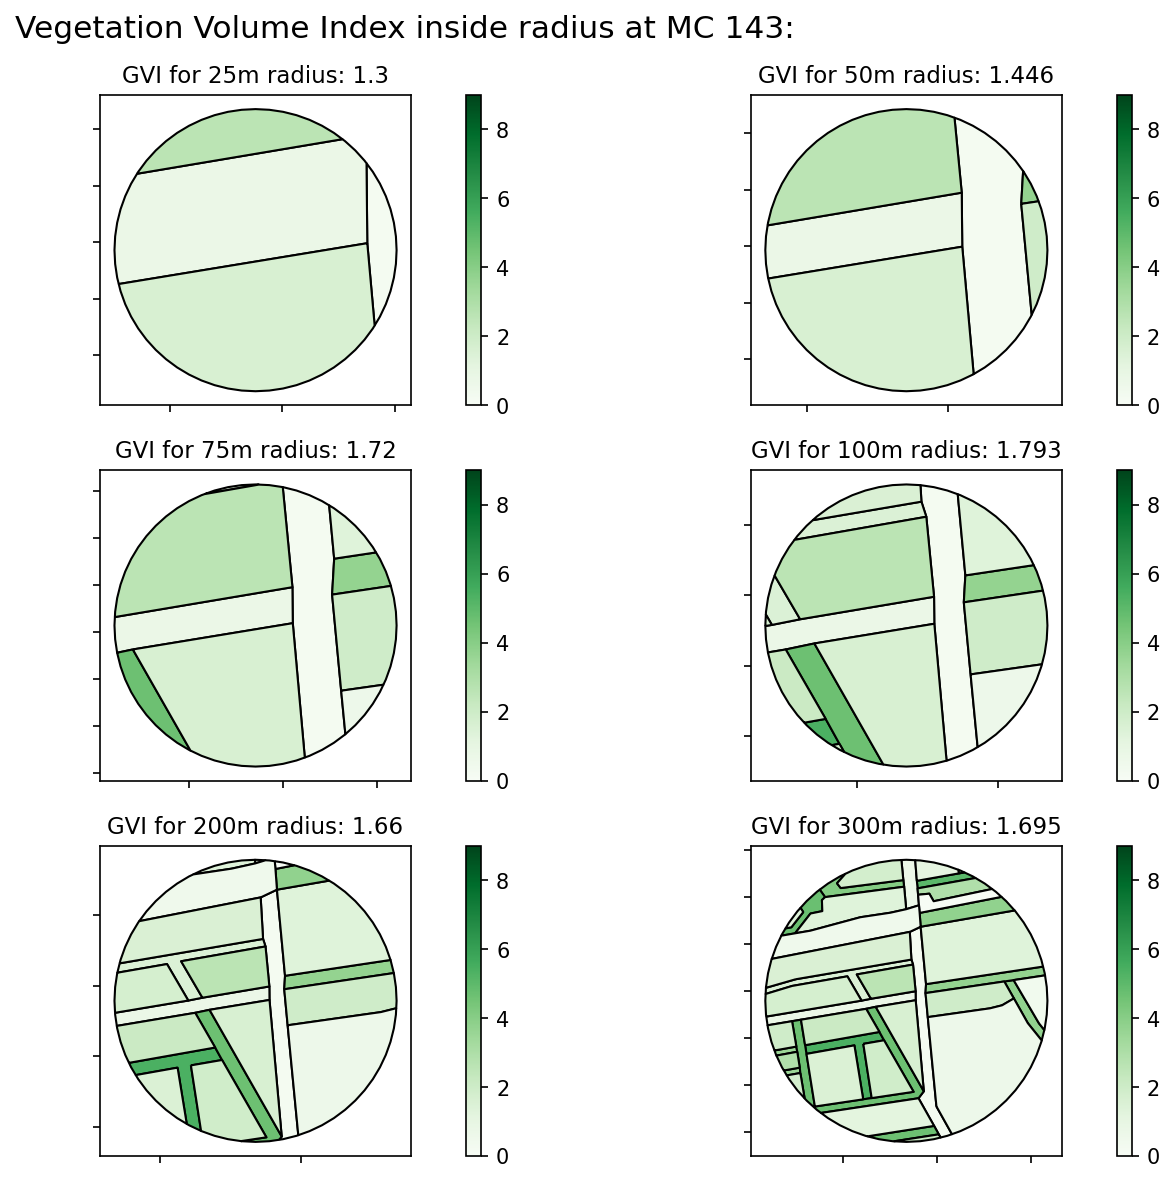

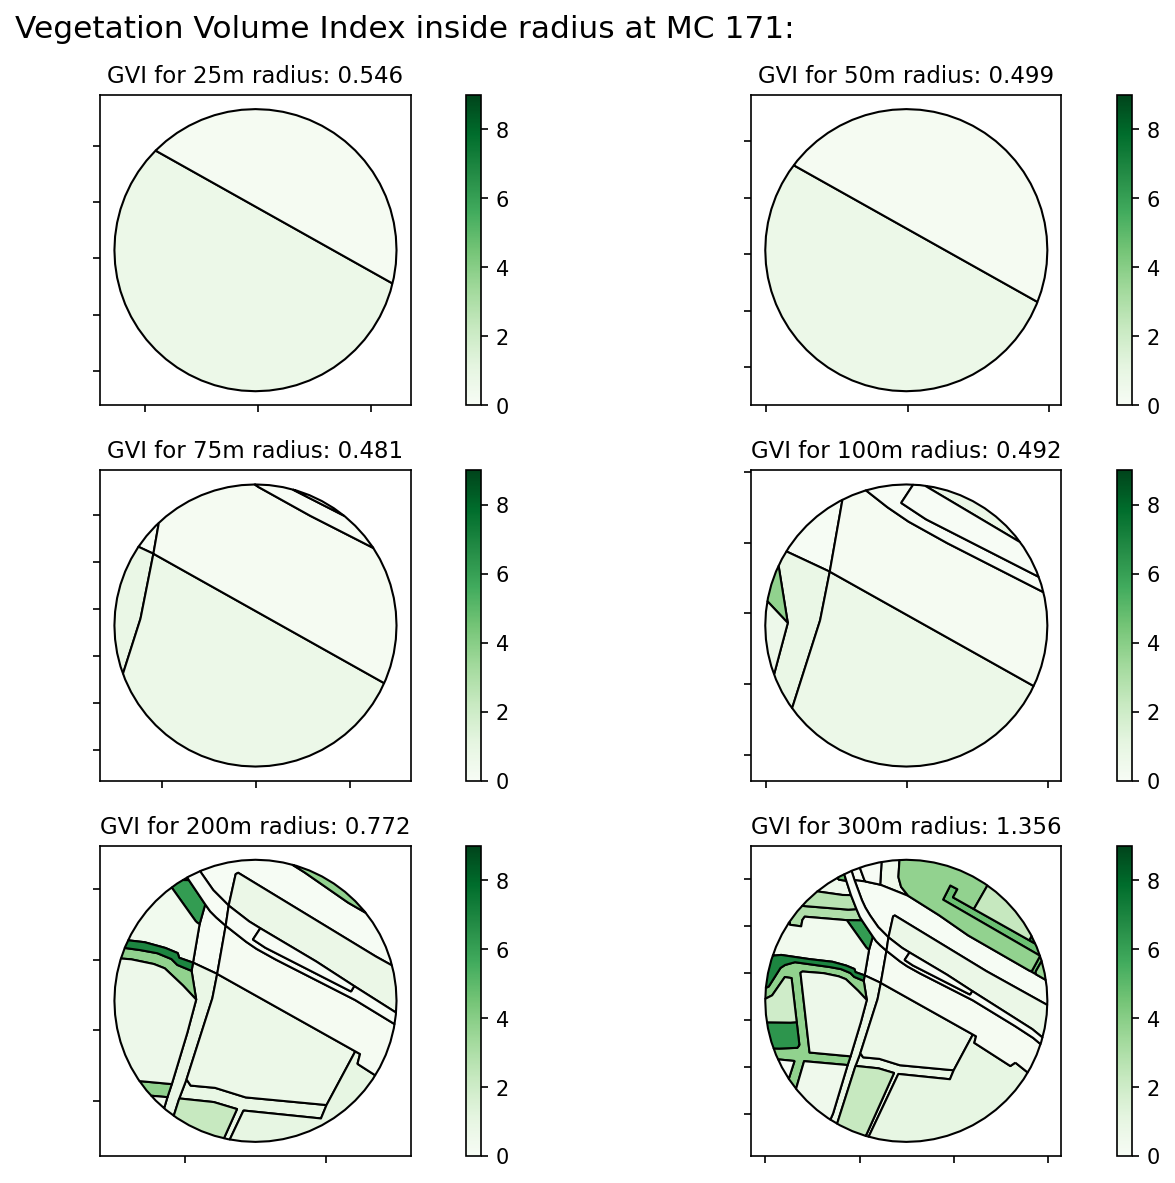

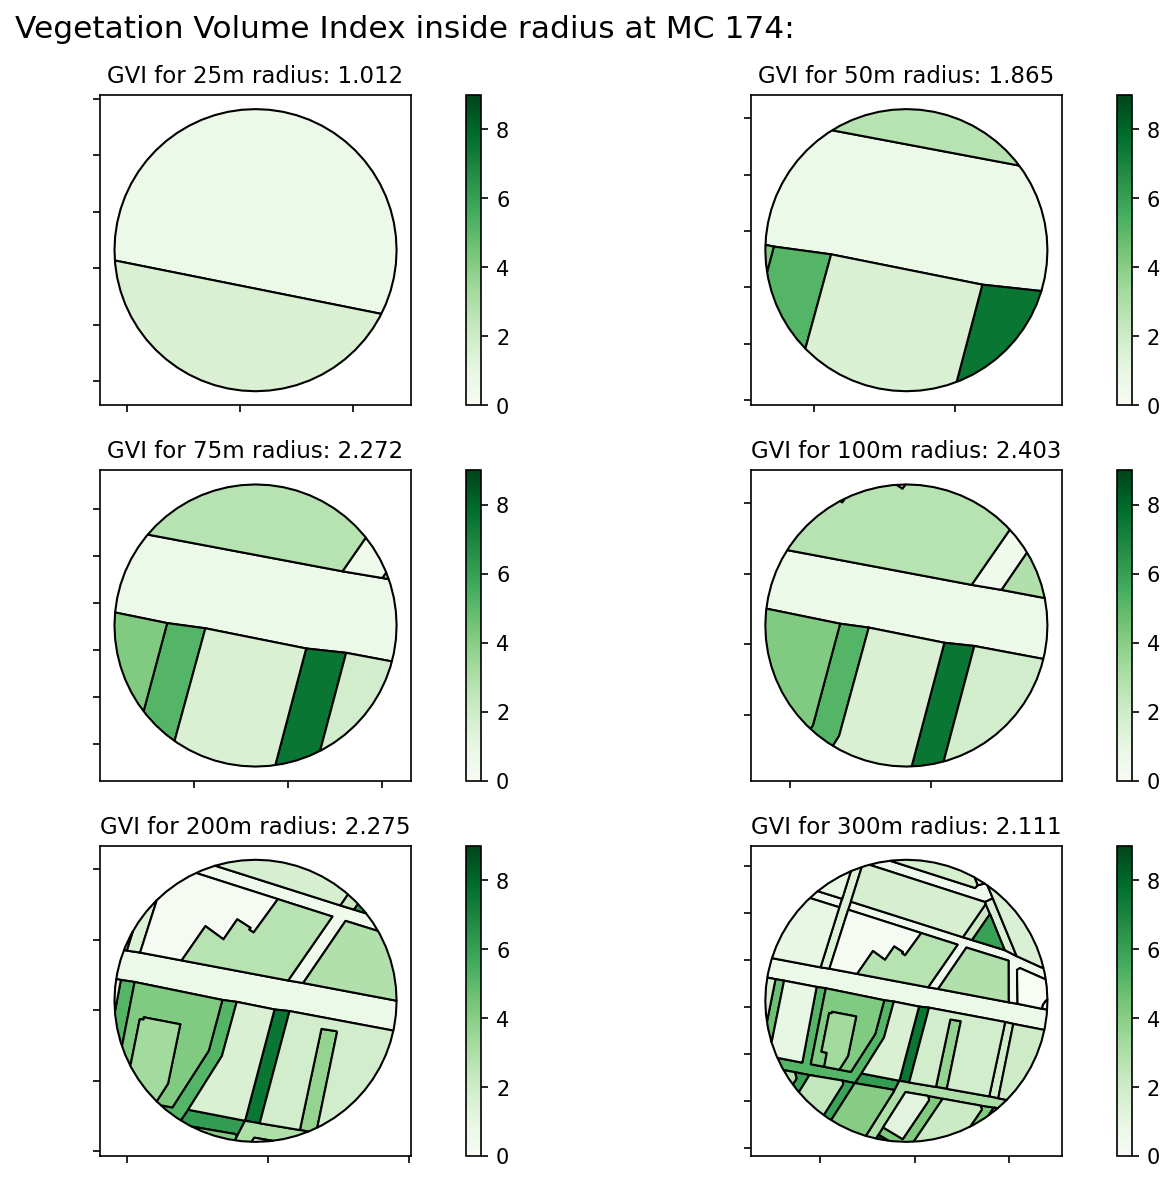

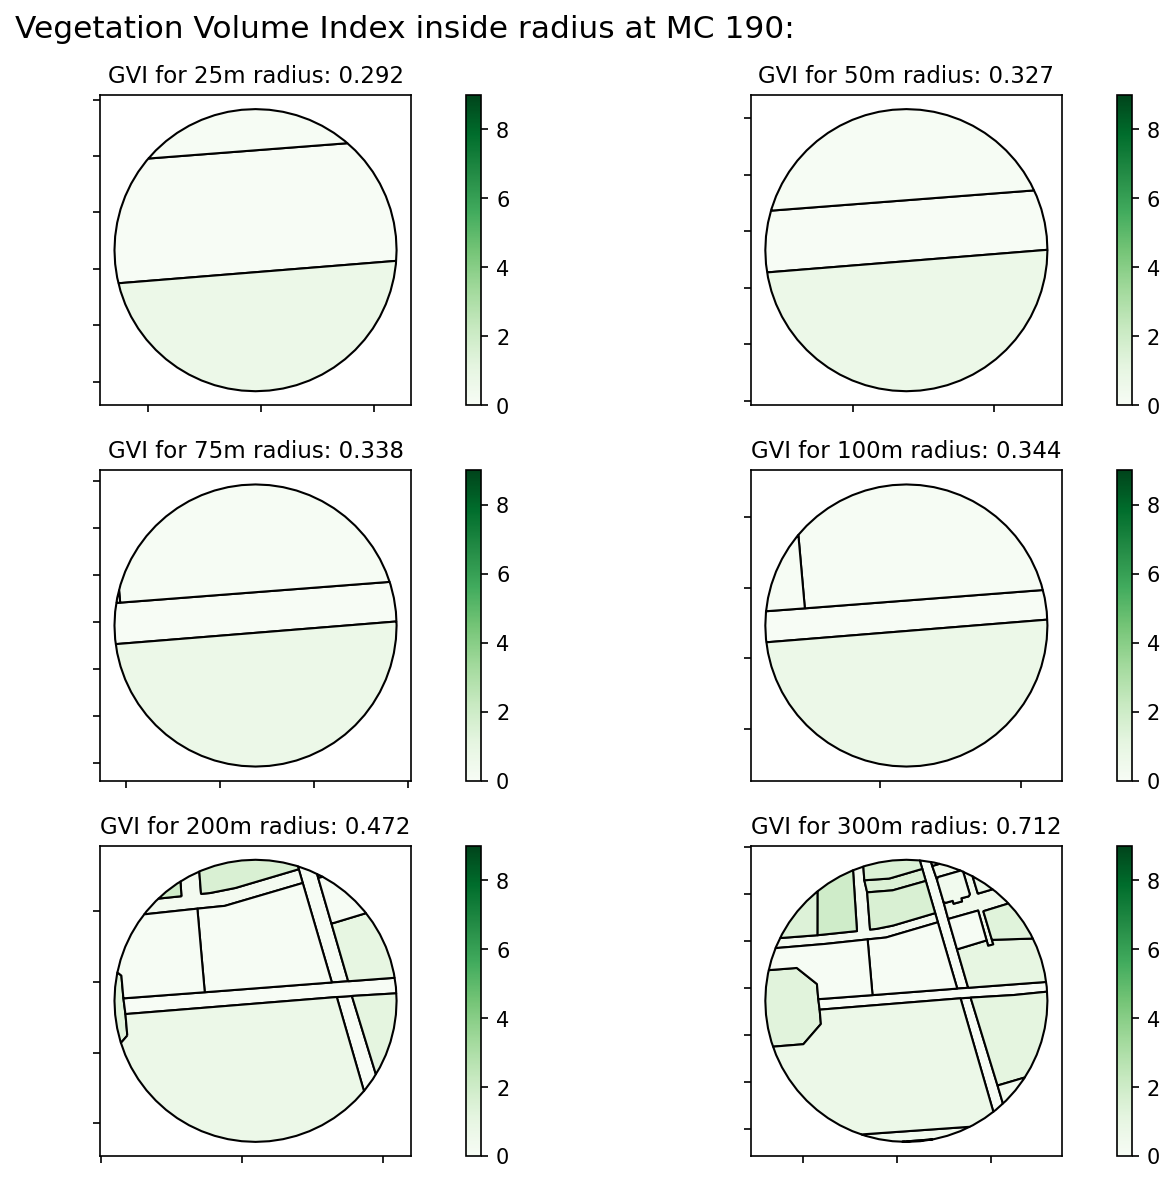

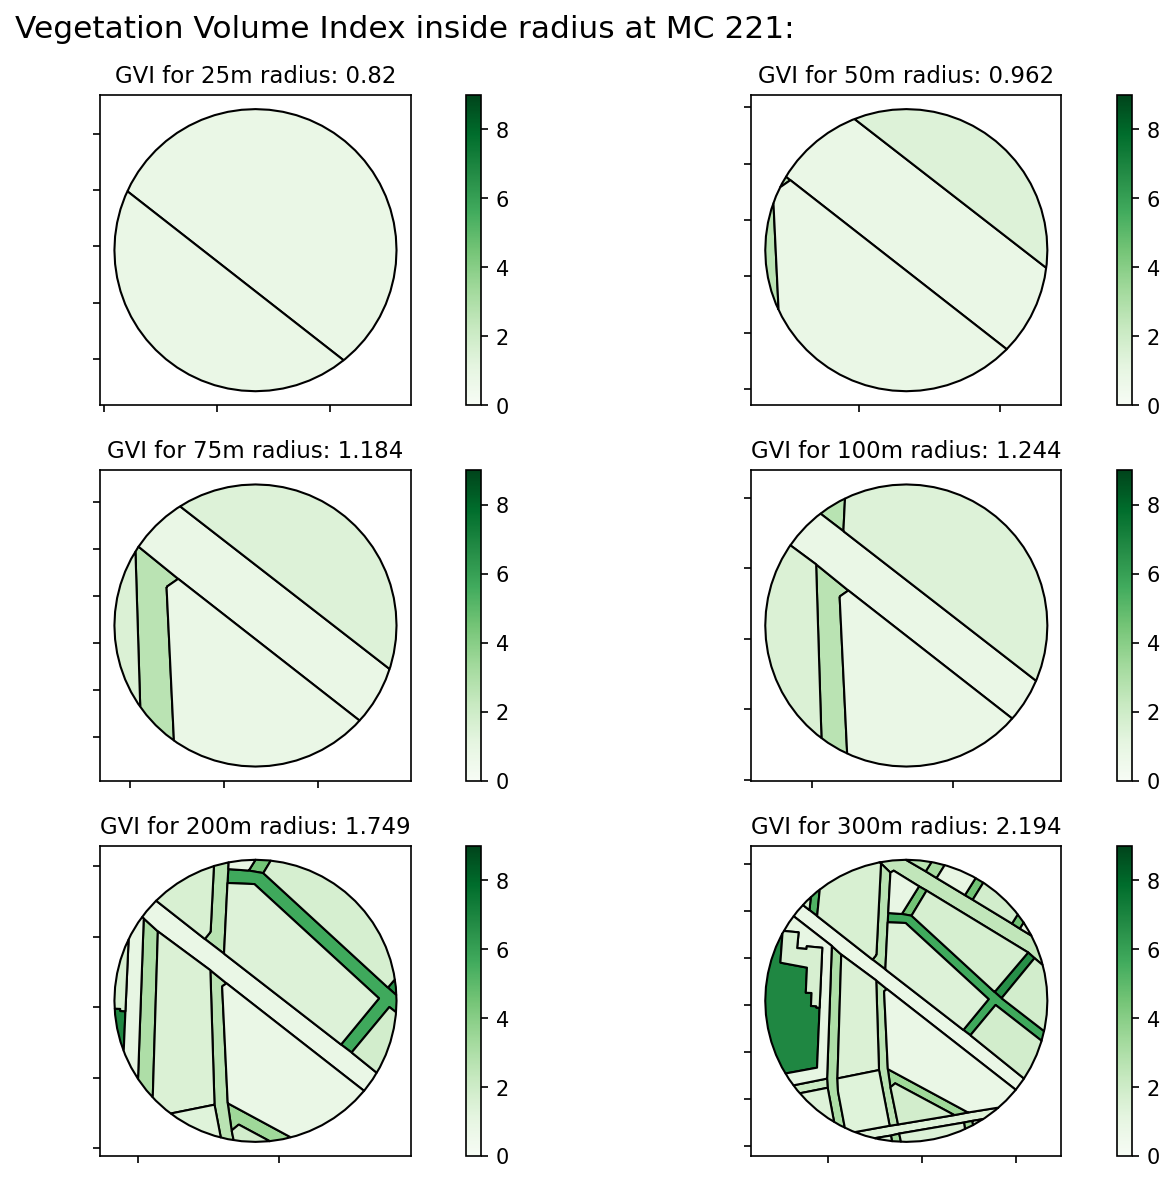

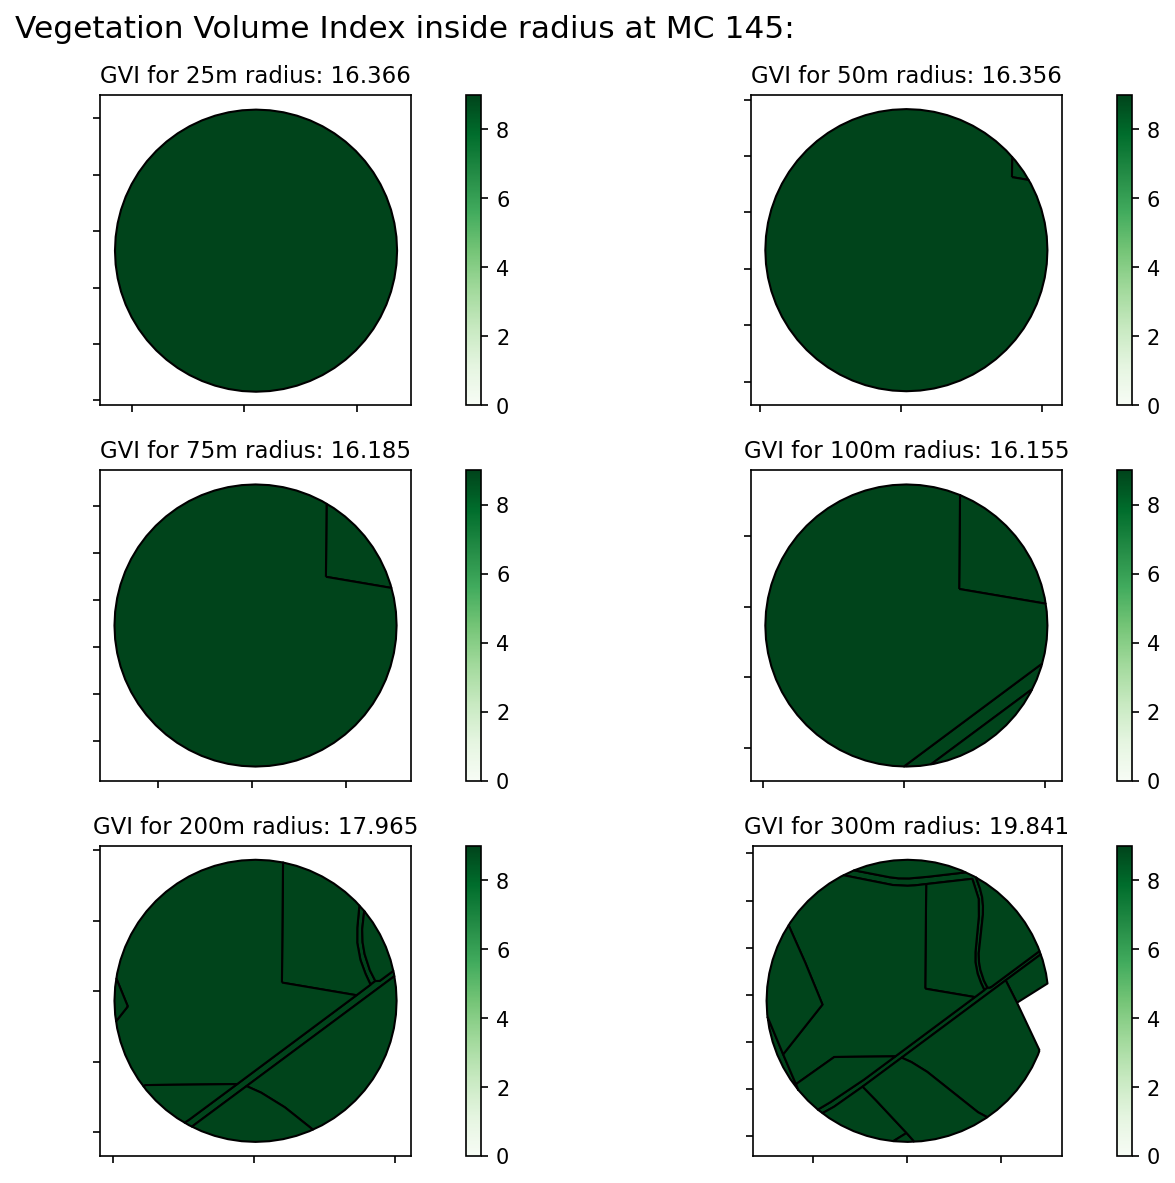

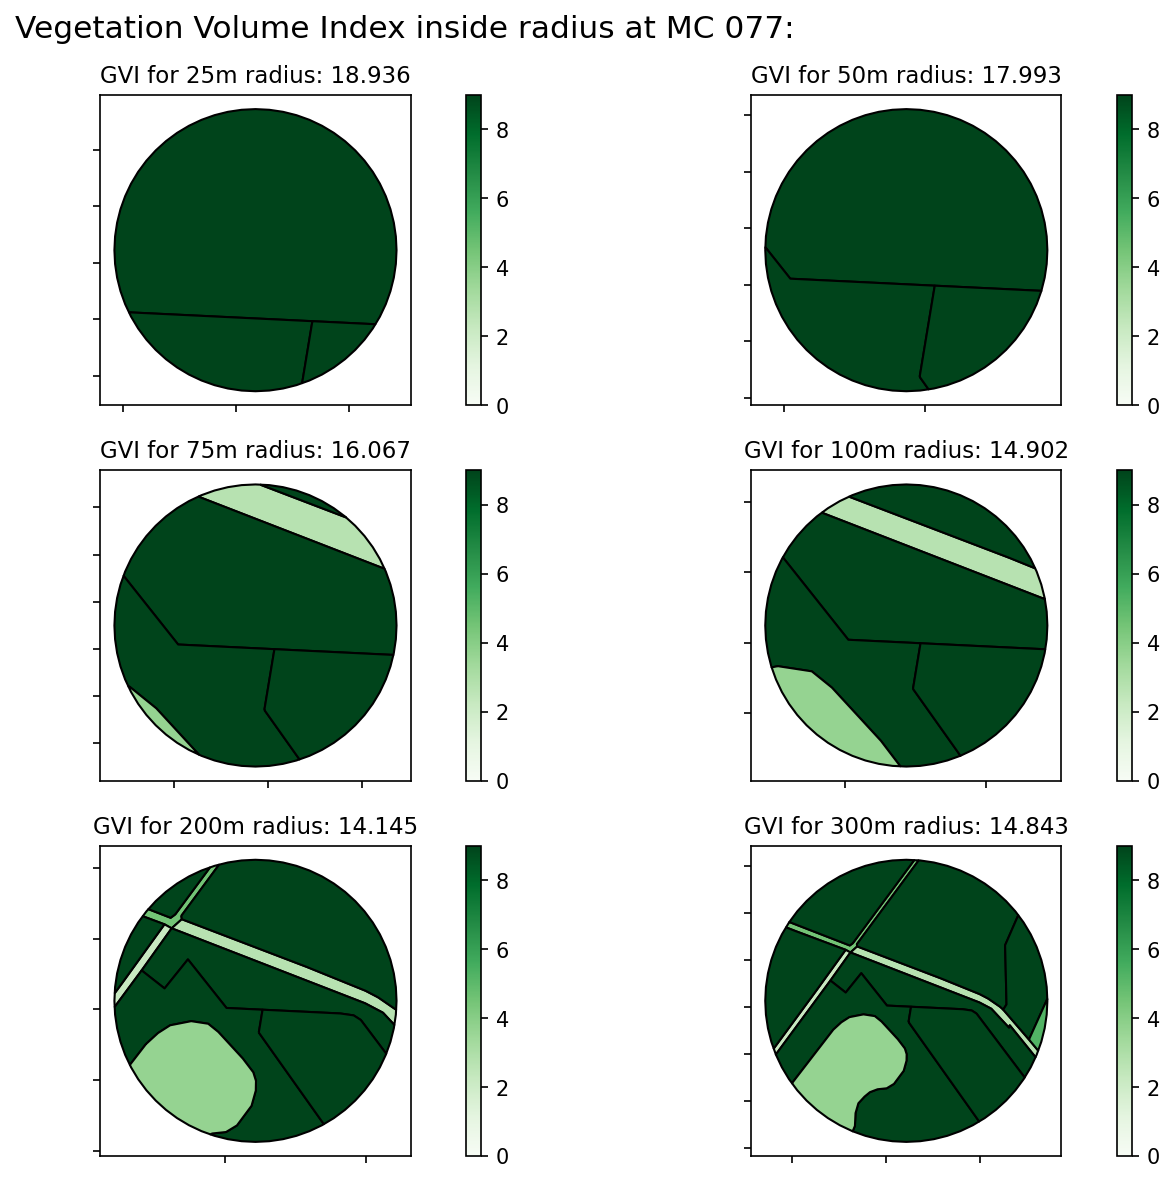

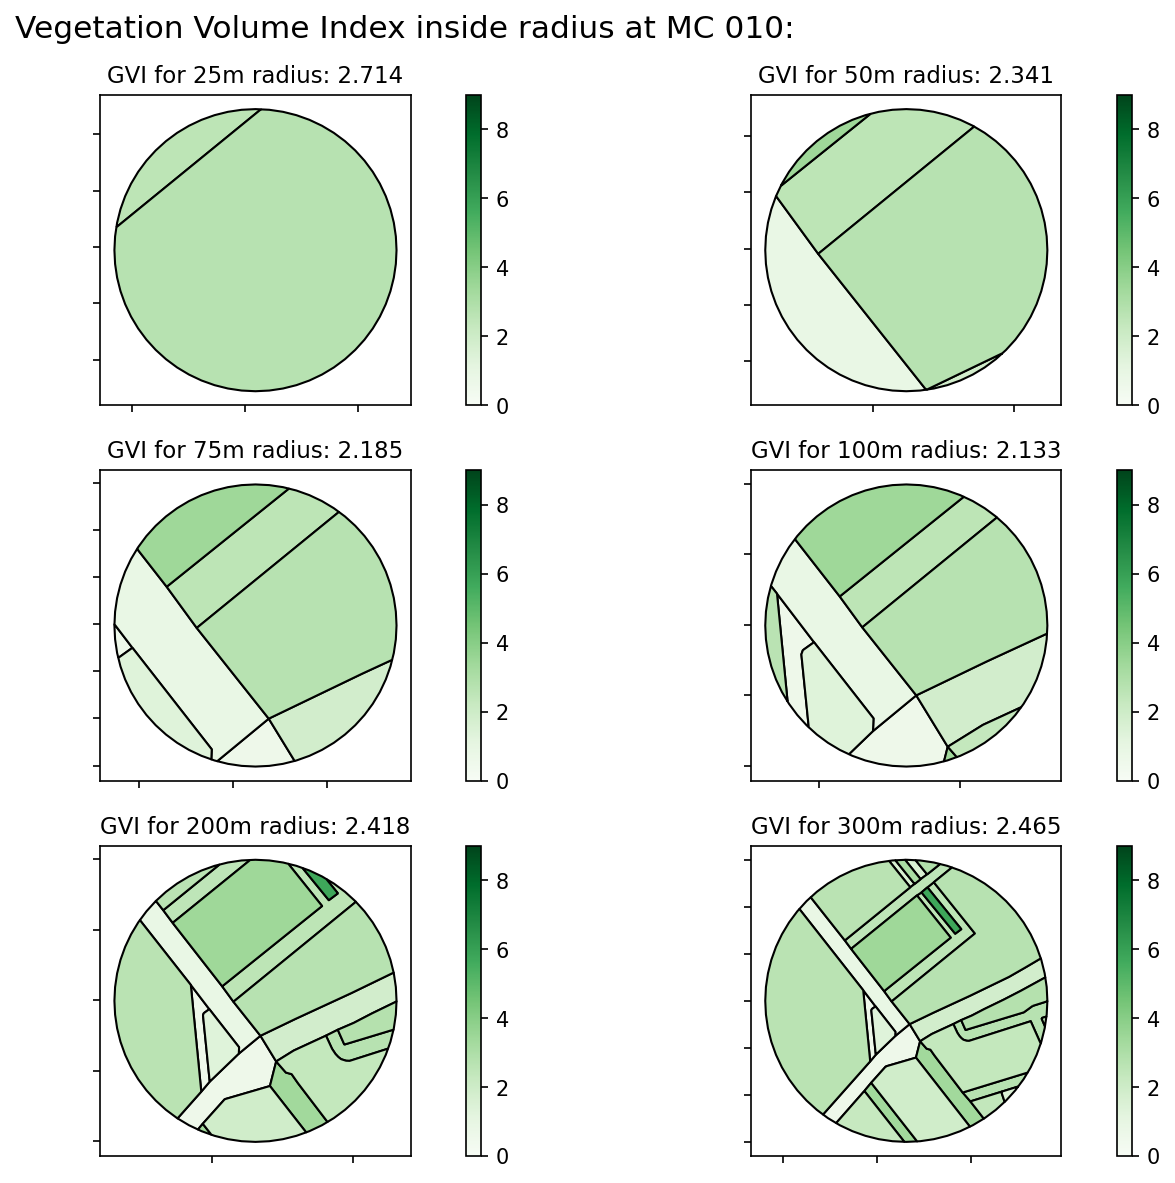

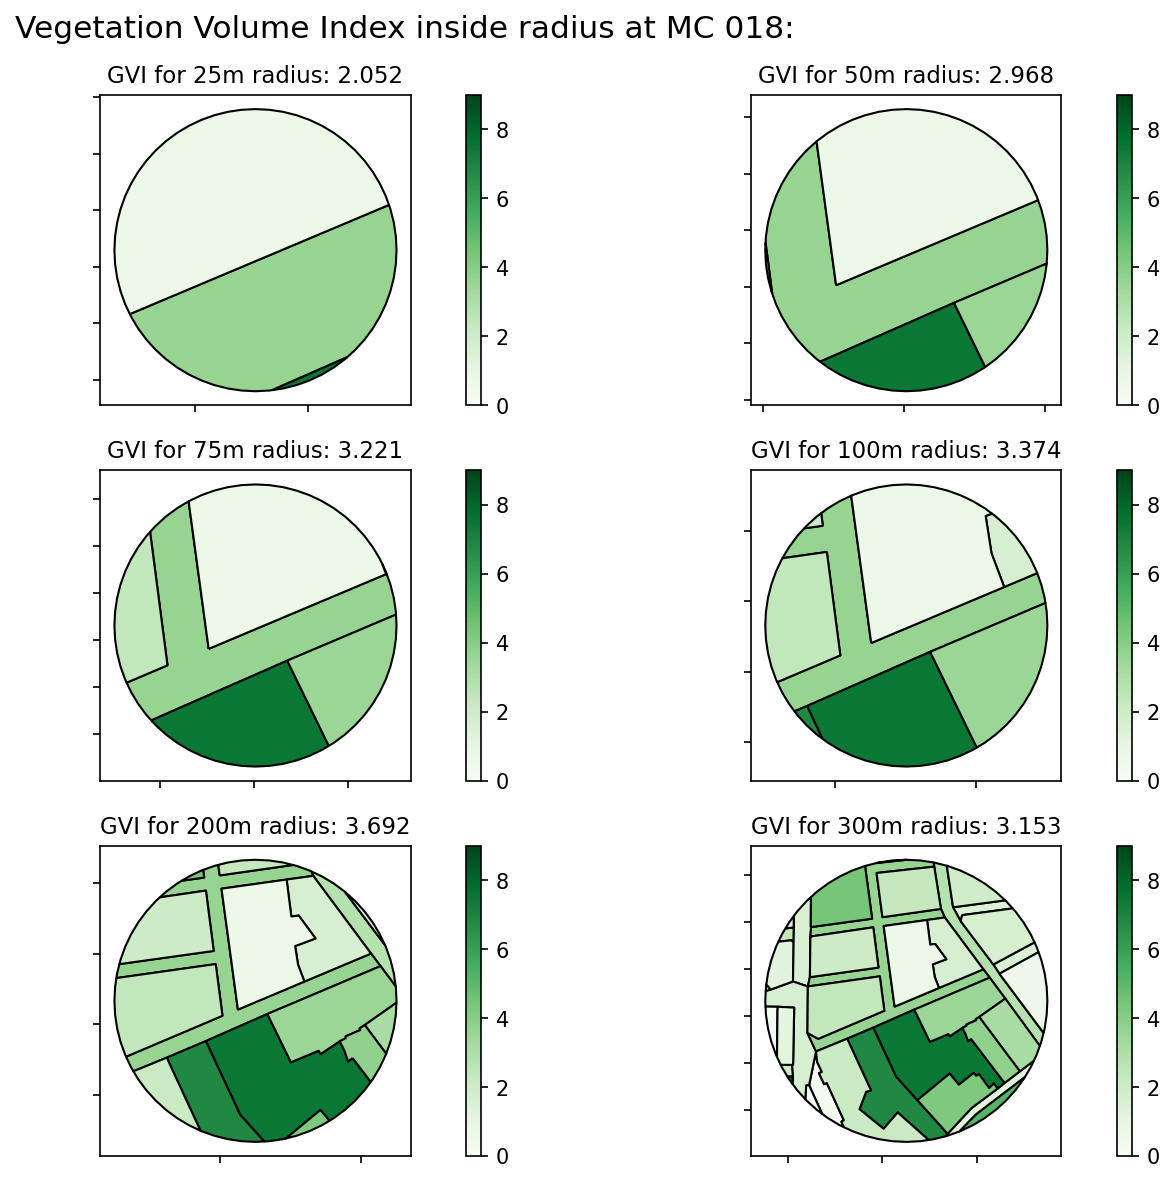

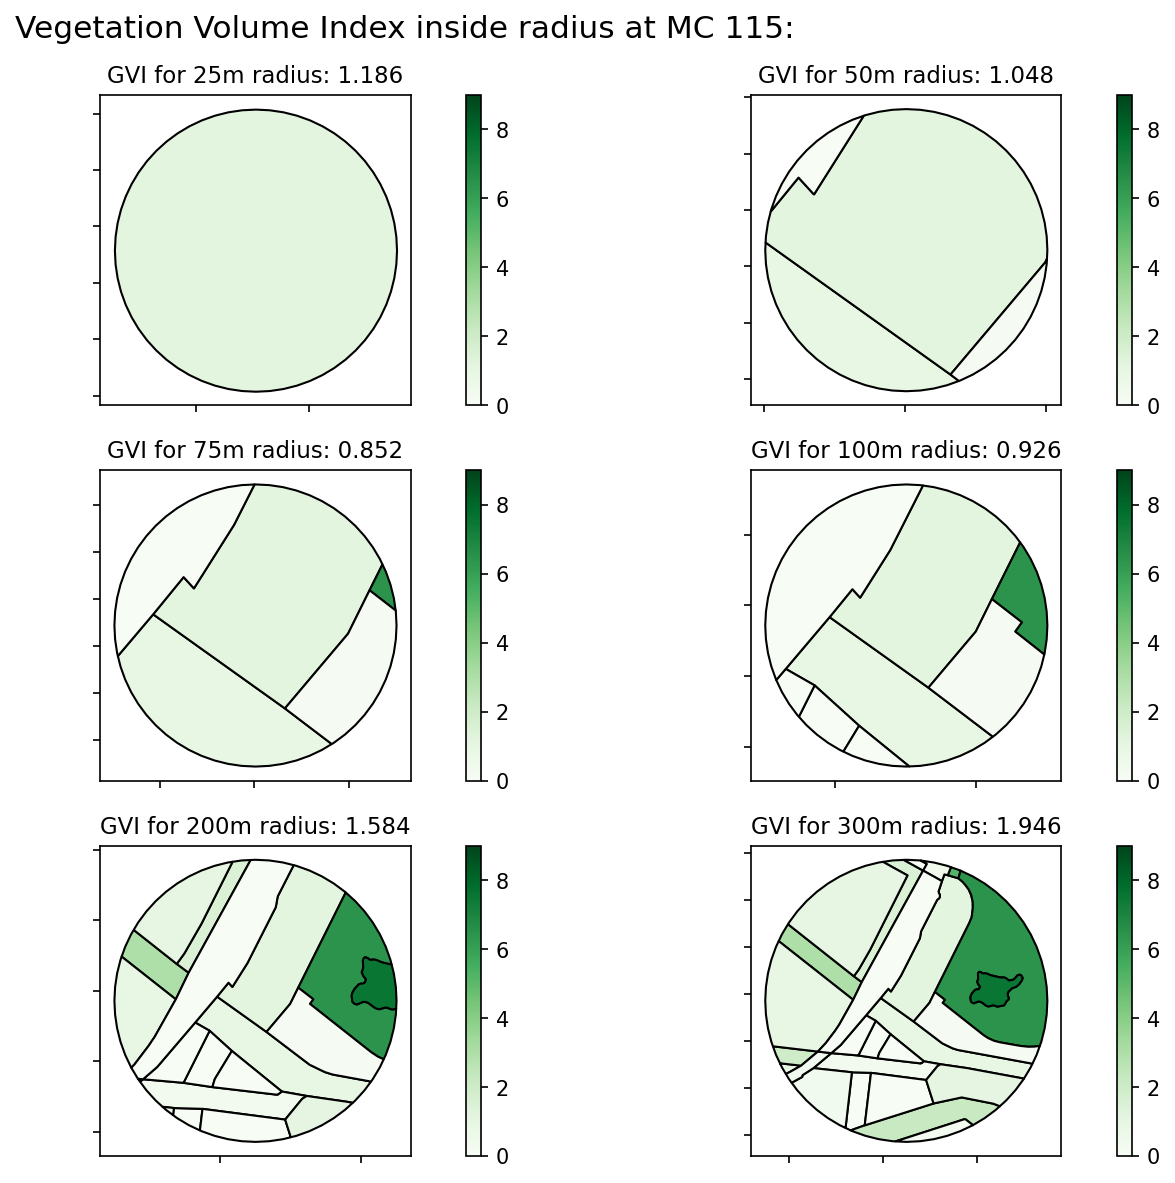

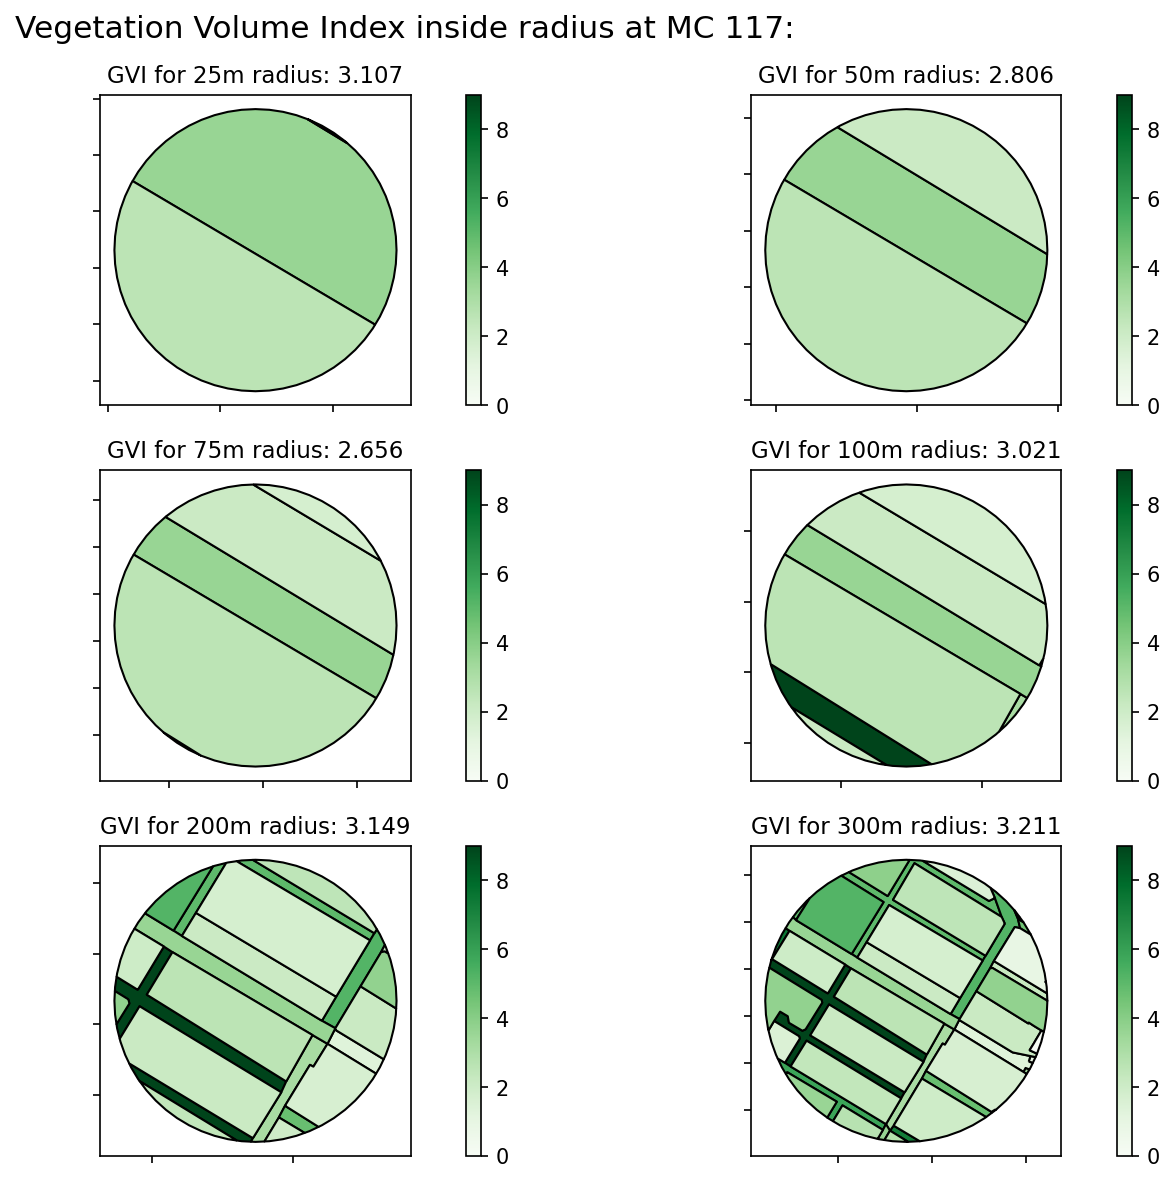

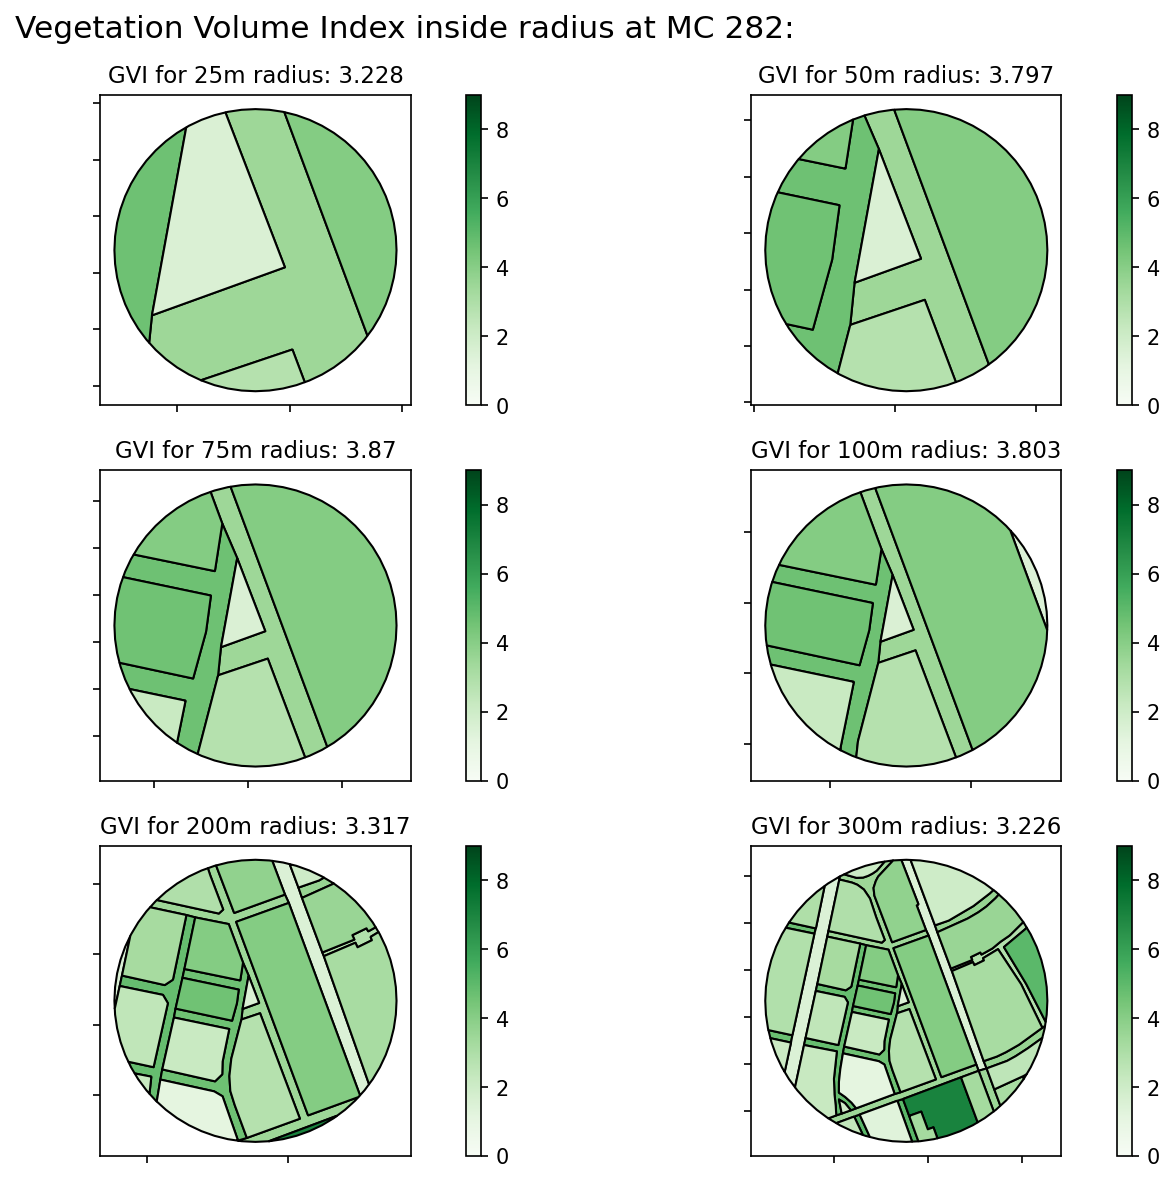

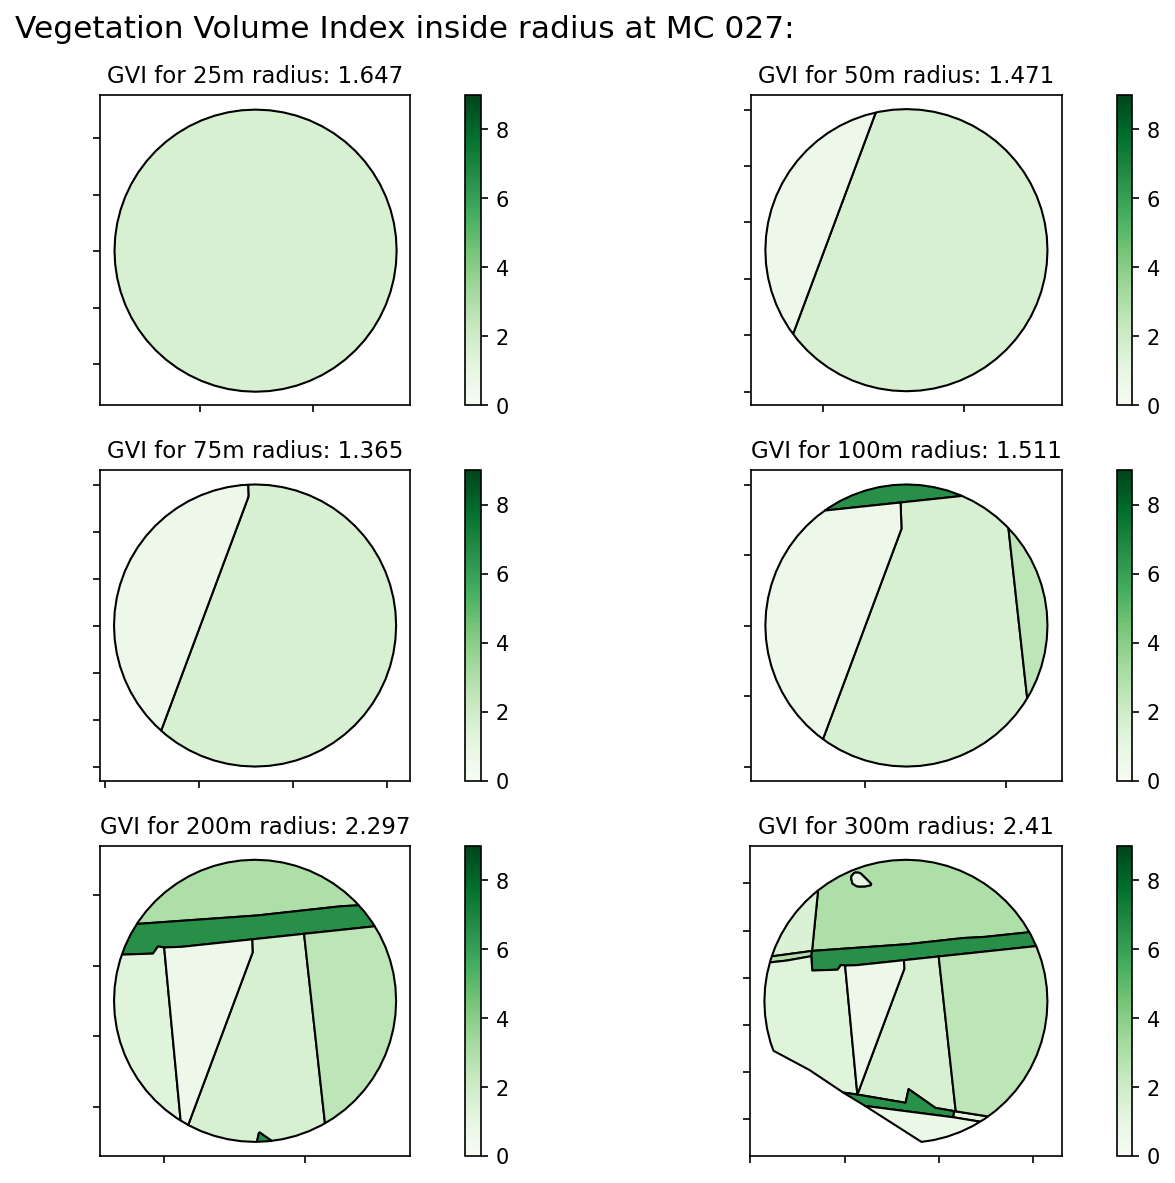

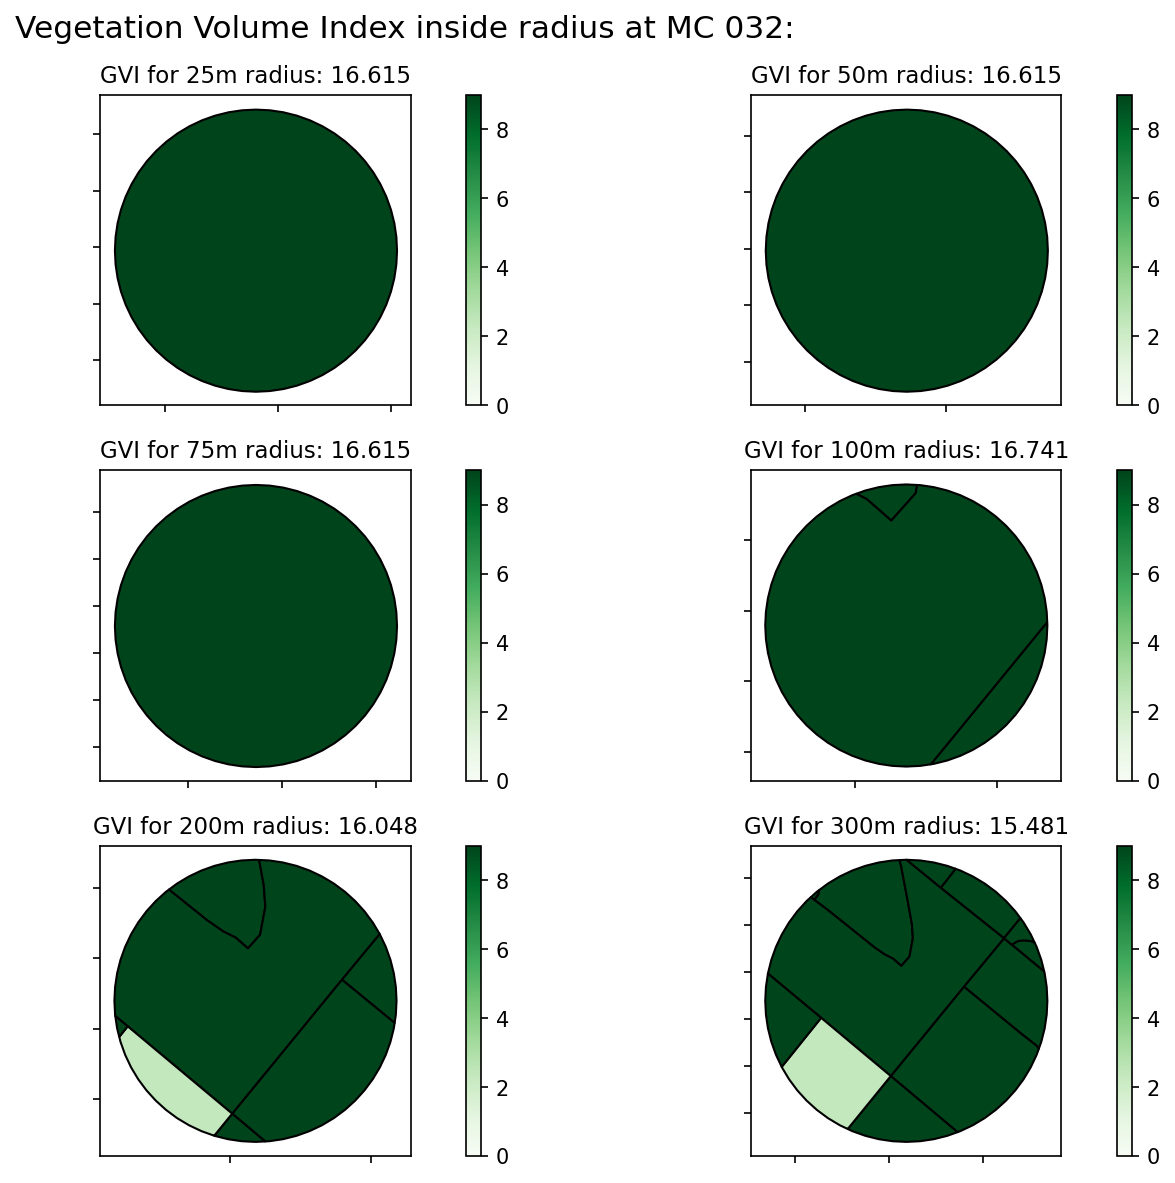

In [38]:
# plot greenery 
import matplotlib.pyplot as plt 

for n in range(len(sites['id'])):
    name = sites['id'][n]
    
    radius = [25,50,75,100,200,300]
    coordinate = sites['geometry'][n]


    fig, axs = plt.subplots((len(radius)//2), 2, figsize=(12, 8), dpi=150)
    fig.suptitle(f'Vegetation Volume Index inside radius at {name}:', fontsize =15)


    for n in range(len(radius)):
        
        # intersect 
        buffer  = geopandas.GeoDataFrame(geometry= [coordinate.buffer(radius[n])], crs=greenery.crs)
        in_buffer_one = geopandas.overlay(greenery, buffer, how='intersection')
        
        # calc weighted mean GVI
        in_buffer_one['area'] = in_buffer_one['geometry'].area 
        in_buffer_one['factor_greenery'] = in_buffer_one['area'] / in_buffer_one['area'].sum()
        in_buffer_one['weighted_greenery'] = (in_buffer_one['factor_greenery']) * in_buffer_one['vegvol2020']
        current_GVI = round(in_buffer_one['weighted_greenery'].sum(),3)

        # plot different GVI over radius
        row = n//2
        column = 0 if (n+1)%2 != 0 else 1
        
        ax = in_buffer_one.plot(ax =axs[row, column] , 
                                column='vegvol2020', 
                                cmap='Greens', vmin= 0, vmax = 9,
                                legend=True, edgecolor='black')
        axs[row, column].set_title(f'GVI for {radius[n]}m radius: {current_GVI}', {'fontsize':11})
        axs[row, column].set_xticklabels([])
        axs[row, column].set_yticklabels([])
        plt.tight_layout()
           
    plt.savefig(f"output/green_volume/compare_{name}.png", dpi = 450)
    plt.show()


In [39]:
sites = pandas.DataFrame(sites.drop(['geometry'], axis = 1))
sites.to_csv('output/green_volume/buffer_values.csv')
sites.head(5)

id  GVI_25  GVI_50  GVI_100  GVI_200
0  MC 042   4.050   3.672    3.570    3.171
1  MC 124   2.521   2.224    2.558    3.589
2  MC 143   1.300   1.446    1.793    1.660
3  MC 171   0.546   0.499    0.492    0.772
4  MC 174   1.012   1.865    2.403    2.275

### most informative radius area

In [40]:
#  distribution between sites
import pandas as pd
sites_analysis = sites
sites_analysis['id'] = sites_analysis['id'].apply(lambda x: x.lower().replace(' ',''))
sites_analysis = sites_analysis.set_index('id')
sites_difference = pd.DataFrame((sites_analysis.std(axis= 1) / sites_analysis.mean(axis = 1))*100 , columns=['rstd'])
sites_difference['min_to_max'] = sites_analysis.max(axis= 1) - sites_analysis.min(axis= 1) 
sites_difference['std'] = sites_analysis.std(axis =1)

pd.concat([sites_analysis, sites_difference], axis =1)
# RESULT: low variance between different sites

GVI_25  GVI_50  GVI_100  GVI_200       rstd  min_to_max       std
id                                                                      
mc042   4.050   3.672    3.570    3.171   9.992645       0.879  0.361309
mc124   2.521   2.224    2.558    3.589  21.901360       1.365  0.596374
mc143   1.300   1.446    1.793    1.660  14.159851       0.493  0.219442
mc171   0.546   0.499    0.492    0.772  22.872018       0.280  0.132029
mc174   1.012   1.865    2.403    2.275  33.245917       1.391  0.627932
mc190   0.292   0.327    0.344    0.472  21.893366       0.180  0.078542
mc221   0.820   0.962    1.244    1.749  34.342987       0.929  0.409969
mc145  16.366  16.356   16.155   17.965   5.038522       1.810  0.841962
mc077  18.936  17.993   14.902   14.145  14.115906       4.791  2.328278
mc010   2.714   2.341    2.133    2.418  10.019197       0.581  0.240611
mc018   2.052   2.968    3.374    3.692  23.531793       1.640  0.711013
mc115   1.186   1.048    0.926    1.584  24.097959       0.658  0.285802
mc117   3.107   2.806    3.021    3.149   5.056946       0.343  0.152758
mc282   3.228   3.797    3.803    3.317   8.673645       0.575  0.306722
mc027   1.647   1.471    1.511    2.297  22.203432       0.826  0.384452
mc032  16.615  16.615   16.741   16.048   1.879695       0.693  0.310239

In [ ]:
# load emission data
import pandas as pd 
from sklearn.feature_selection import mutual_info_regression


no2 = pd.read_csv('../data/datasets/df_processed.csv')[['id', 'NO2']].groupby('id').mean()
no2_vvi = pd.concat([no2, sites_analysis], axis= 1).sort_values('NO2', axis=0)

results = {'correlation' : [],
           'mutual_info' : [],}

for radius in list(sites_analysis.columns):
    results['correlation'].append(round(no2_vvi['NO2'].corr(no2_vvi[radius], method='pearson'),4))
    results['mutual_info'].append(round(mutual_info_regression(no2_vvi.filter(['NO2']), no2_vvi[radius])[0],4))


results = pd.DataFrame(results).transpose()
results.columns = list(sites_analysis.columns)
results